In [351]:
import os
import pandas as pd
import csv
import pickle as pkl
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch import nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import datetime
from nltk import pos_tag
from tqdm import tqdm

In [352]:
X = pkl.load(open('X.pkl', 'rb'))
Y = pkl.load(open('Y.pkl', 'rb'))

In [353]:
X = torch.stack(X)
Y = torch.stack(Y)

In [354]:
Y = Y.squeeze(1)

In [355]:
X

tensor([[0.4009, 0.6468, 0.6278, 0.4447],
        [0.4895, 0.7935, 0.6004, 0.4472],
        [0.4148, 0.5295, 0.6285, 0.4397],
        ...,
        [0.2975, 0.7910, 0.6281, 0.4400],
        [0.5141, 0.7882, 0.6114, 0.4399],
        [0.4998, 0.7996, 0.6347, 0.4428]], dtype=torch.float64)

In [356]:
Y = Y/100

In [357]:
Y

tensor([[0.2800, 0.2800, 0.7840],
        [0.1300, 0.1400, 0.1820],
        [0.1700, 0.3200, 0.5440],
        ...,
        [0.1200, 0.1800, 0.2160],
        [0.2100, 0.2200, 0.4620],
        [0.0900, 0.1700, 0.1530]], dtype=torch.float64)

In [358]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [359]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [360]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(device)

cpu


In [361]:
class FinalModel(nn.Module):
    def __init__(self, ) -> None:
        super().__init__()
        self.input = nn.Linear(4, 10)
        self.linear_stack = nn.Sequential(
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(10, 20),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(20, 40),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(40, 20),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(10, 5),
            nn.ReLU(),
        )
        self.output = nn.Linear(5, 3)
    def forward(self, x):
        x = self.input(x)
        x = self.linear_stack(x)
        x = self.output(x)
        return x
    


In [362]:
model_train = FinalModel().to(device)
best_loss = 10000
best_model = model_train.state_dict()
epochs = 500
learning_rate = 20e-5
loss_fn = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model_train.parameters(), lr=learning_rate)
test_loss = []
train_loss = []
for i in range(epochs):
    for X, Y in train_loader:
        X, Y = X.to(device), Y.to(device)
        Y_pred = model_train(X.float())
        # continue
        loss = loss_fn(Y_pred, Y.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss.append(loss.item())
    # Test Loss
    with torch.no_grad():
        for X, Y in test_loader:
            X, Y = X.to(device), Y.to(device)
            Y_pred = model_train(X.float())
            test_loss_fn = loss_fn(Y_pred, Y.float())
        print(f'Epoch {i}, Training Loss: {loss.item()}, Test Loss: {test_loss_fn.item()}')
        test_loss.append(test_loss_fn.item())
        if(test_loss_fn.item() < best_loss):
            best_loss = test_loss_fn.item()
            best_model = model_train.state_dict()

Epoch 0, Training Loss: 0.1666252762079239, Test Loss: 0.22707043588161469
Epoch 1, Training Loss: 0.2031620889902115, Test Loss: 0.15676625072956085
Epoch 2, Training Loss: 0.1615014523267746, Test Loss: 0.14724251627922058
Epoch 3, Training Loss: 0.15260179340839386, Test Loss: 0.14661838114261627
Epoch 4, Training Loss: 0.1321534663438797, Test Loss: 0.14503812789916992
Epoch 5, Training Loss: 0.12031839042901993, Test Loss: 0.10460052639245987
Epoch 6, Training Loss: 0.10470487922430038, Test Loss: 0.10783931612968445
Epoch 7, Training Loss: 0.08449456840753555, Test Loss: 0.11043151468038559
Epoch 8, Training Loss: 0.0844825729727745, Test Loss: 0.0684710368514061
Epoch 9, Training Loss: 0.06161109730601311, Test Loss: 0.08222653716802597
Epoch 10, Training Loss: 0.07082599401473999, Test Loss: 0.0704929307103157
Epoch 11, Training Loss: 0.05504673719406128, Test Loss: 0.046555615961551666
Epoch 12, Training Loss: 0.05566100403666496, Test Loss: 0.08255022019147873
Epoch 13, Train

Text(0.5, 1.0, '20240513-000843')

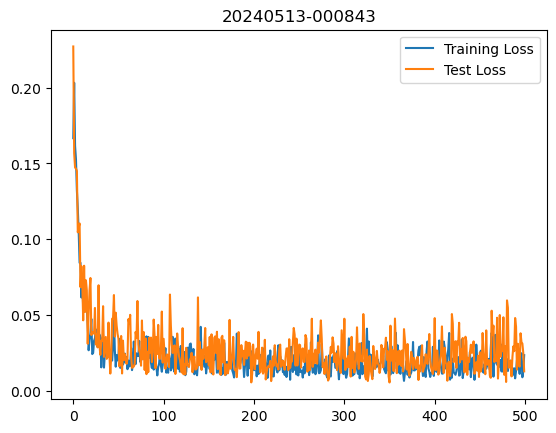

In [363]:
plt.plot(train_loss[:], label='Training Loss')
plt.plot(test_loss[:], label='Test Loss')
plt.legend()
datestring = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
plt.title(datestring)
# plt.savefig(f'./train_logs/{datestring}.png')

In [372]:
best_loss

0.005600449163466692

In [373]:
model_train(torch.stack([X[0]]).float())*100

tensor([[15.1670, 23.6476, 38.1506]], grad_fn=<MulBackward0>)

In [374]:
torch.save(best_model, f'./models/{datestring}.pth')

In [375]:
datestring

'20240513-000843'

In [376]:
new_model = FinalModel()
new_model.load_state_dict(best_model)

<All keys matched successfully>

In [382]:
array = []
for i in range(len(X_train)):
    X_out = new_model(X_train[i].float())
    # print(X_out)
    Y_out= y_train[i]
    # print(Y_out)
    # array.append((sum((X_out - Y_out)**2)).item())
    array.append(loss_fn(X_out, Y_out).item())
print(sorted(array)[::-1])

[0.2011500284051805, 0.18895131650959976, 0.18688809191517164, 0.17472014121384824, 0.13892112757741676, 0.1270202865766803, 0.12578330875847465, 0.12323258245759115, 0.1187195247172189, 0.11719099064295757, 0.1160505637441358, 0.11067908338115941, 0.11022256463627417, 0.1081915341093563, 0.10813618735832527, 0.10343252864601533, 0.09501176616425804, 0.09442471886353655, 0.08679273945935058, 0.0807469627821752, 0.07302661170000548, 0.07287687023899038, 0.07021615416976812, 0.06970297863456058, 0.06676412329178102, 0.06563443131296572, 0.06239003544472113, 0.059620689529874586, 0.05877829371086924, 0.056887364579072695, 0.05493242401792902, 0.052938694548623176, 0.05188776436687726, 0.0510508308774413, 0.04841959344998794, 0.04768541974351755, 0.047487659631258304, 0.04648968139472787, 0.04401580159556451, 0.04301784670677398, 0.04143234595978554, 0.03637148672818103, 0.03590679120978386, 0.03408141886392325, 0.033499510665802354, 0.03321967660503005, 0.0330014809253417, 0.0327808031793

In [383]:
np.mean(array)

0.018282363001289735

In [371]:
# array.sort()
# count = 0
# median = np.median(array)
# for i in array:
#     if(i > median):
#         count += 1
# print(count/len(array))